In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import geopandas as gpd

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', None)

In [ ]:
df = pd.read_csv("/content/prosperLoanData.csv")
category_mapping = {
    0: 'Not Available',
    1: 'Debt Consolidation',
    2: 'Home Improvement',
    3: 'Business',
    4: 'Personal Loan',
    5: 'Student Use',
    6: 'Auto',
    7: 'Other',
    8: 'Baby&Adoption',
    9: 'Boat',
    10: 'Cosmetic Procedure',
    11: 'Engagement Ring',
    12: 'Green Loans',
    13: 'Household Expenses',
    14: 'Large Purchases',
    15: 'Medical/Dental',
    16: 'Motorcycle',
    17: 'RV',
    18: 'Taxes',
    19: 'Vacation',
    20: 'Wedding Loans'
}

df['ListingCategory'] = df['ListingCategory (numeric)'].map(category_mapping)

In [ ]:
features = df.iloc[:, :27]
features.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperRating (Alpha),ProsperScore,ListingCategory (numeric),BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,CurrentlyInGroup,GroupKey,DateCreditPulled,CreditScoreRangeLower,CreditScoreRangeUpper
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,NaN,NaN,NaN,NaN,NaN,NaN,0,CO,Other,Self-employed,2.0,True,True,NaN,2007-08-26 18:41:46.780000000,640.0,659.0
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.0920,0.0820,0.07960,0.0249,0.05470,6.0,A,7.0,2,CO,Professional,Employed,44.0,False,False,NaN,2014-02-27 08:28:14,680.0,699.0
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090000000,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,NaN,NaN,NaN,NaN,NaN,NaN,0,GA,Other,Not available,NaN,False,True,783C3371218786870A73D20,2007-01-02 14:09:10.060000000,480.0,499.0
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010000000,NaN,36,Current,NaN,0.12528,0.0974,0.0874,0.08490,0.0249,0.06000,6.0,A,9.0,16,GA,Skilled Labor,Employed,113.0,True,False,NaN,2012-10-22 11:02:32,800.0,819.0
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097000000,NaN,36,Current,NaN,0.24614,0.2085,0.1985,0.18316,0.0925,0.09066,3.0,D,4.0,2,MN,Executive,Employed,44.0,True,False,NaN,2013-09-14 18:38:44,680.0,699.0


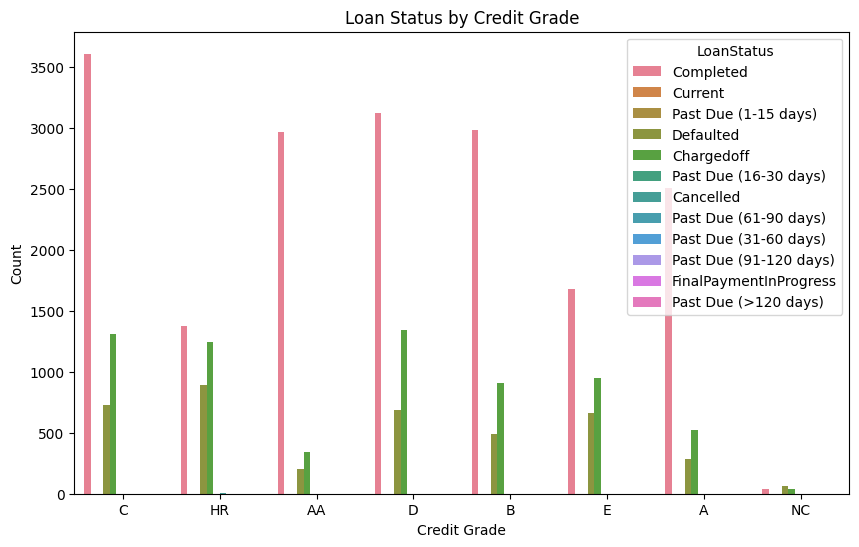

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='CreditGrade', hue='LoanStatus', data=features)
plt.title('Loan Status by Credit Grade')
plt.xlabel('Credit Grade')
plt.ylabel('Count')
plt.show()

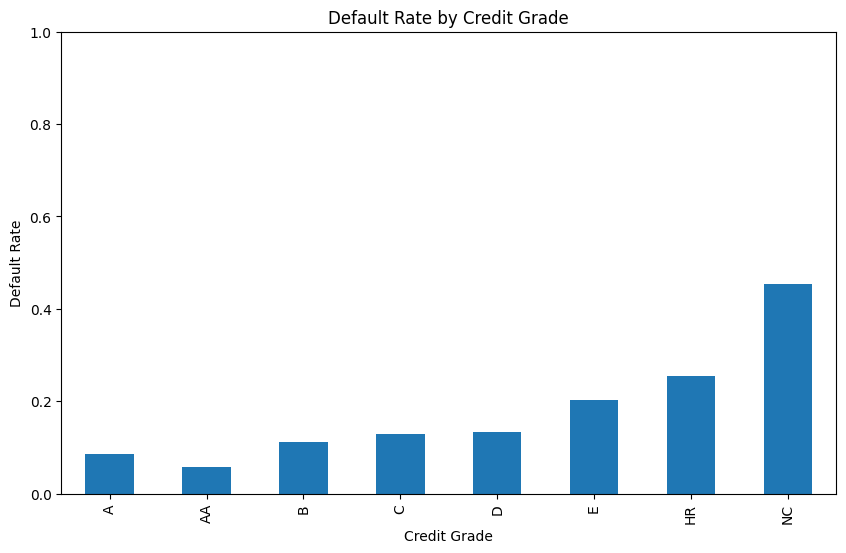

In [ ]:
default_credit_grade = features.groupby('CreditGrade')['LoanStatus'].apply(lambda x: (x == 'Defaulted').mean())

# Create a bar plot to visualize the default rate by credit grade
plt.figure(figsize=(10, 6))
default_credit_grade.plot(kind='bar')
plt.title('Default Rate by Credit Grade')
plt.xlabel('Credit Grade')
plt.ylabel('Default Rate')
plt.ylim(0, 1)
plt.show()

7 dummies for each grade, one grade is omitted in the constant term to account for multicollinearity.

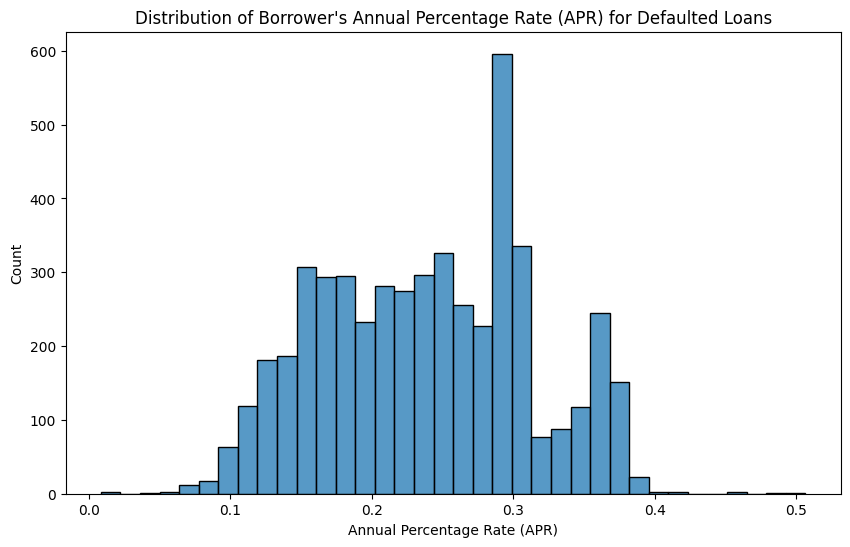

In [ ]:
defaulted_loans = features[features['LoanStatus'] == 'Defaulted']

# Create a histogram to visualize the distribution of BorrowerAPR for defaulted loans
plt.figure(figsize=(10, 6))
sns.histplot(defaulted_loans['BorrowerAPR'])
plt.title("Distribution of Borrower's Annual Percentage Rate (APR) for Defaulted Loans")
plt.xlabel('Annual Percentage Rate (APR)')
plt.ylabel('Count')
plt.show()

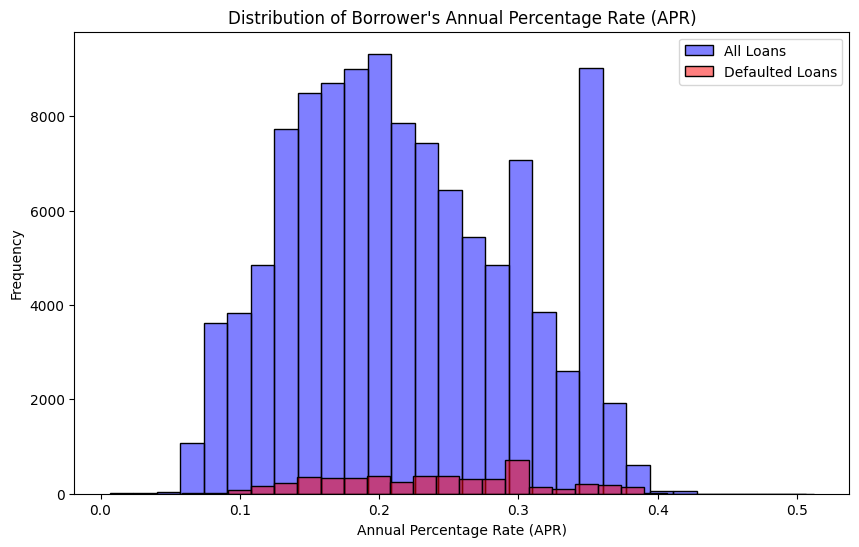

In [ ]:
defaulted_loans = features[features['LoanStatus'] == 'Defaulted']

plt.figure(figsize=(10, 6))

# Determine the bin width based on the overall range of BorrowerAPR
apr_range = features['BorrowerAPR'].max() - features['BorrowerAPR'].min()
apr_binwidth = apr_range / 30

# Plot histogram for all loans (blue)
sns.histplot(features['BorrowerAPR'], color='blue', alpha=0.5, label='All Loans', binwidth=apr_binwidth)

# Plot histogram for defaulted loans (red)
sns.histplot(defaulted_loans['BorrowerAPR'], color='red', alpha=0.5, label='Defaulted Loans', binwidth=apr_binwidth)

plt.title("Distribution of Borrower's Annual Percentage Rate (APR)")
plt.xlabel('Annual Percentage Rate (APR)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

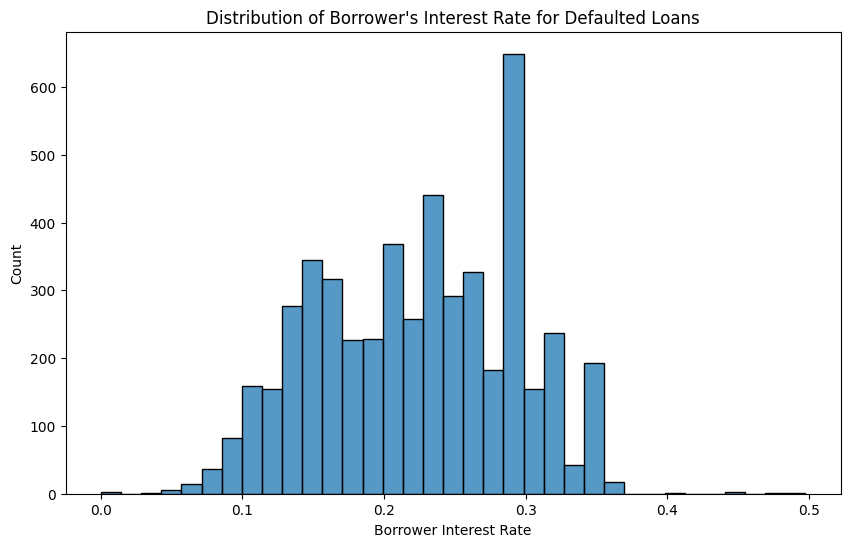

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(defaulted_loans['BorrowerRate'])
plt.title("Distribution of Borrower's Interest Rate for Defaulted Loans")
plt.xlabel('Borrower Interest Rate')
plt.ylabel('Count')
plt.show()

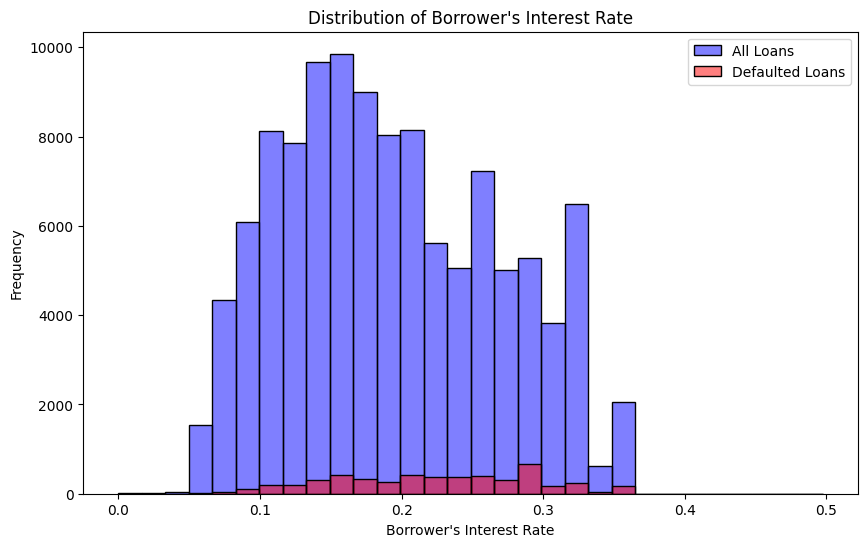

In [ ]:
plt.figure(figsize=(10, 6))

# Determine the bin width based on the overall range of Borrower's interest rate
br_range = features['BorrowerRate'].max() - features['BorrowerRate'].min()
br_binwidth = br_range / 30

# Plot histogram for all loans (blue)
sns.histplot(features['BorrowerRate'], color='blue', alpha=0.5, label='All Loans', binwidth=br_binwidth)

# Plot histogram for defaulted loans (red)
sns.histplot(defaulted_loans['BorrowerRate'], color='red', alpha=0.5, label='Defaulted Loans', binwidth=br_binwidth)

plt.title("Distribution of Borrower's Interest Rate")
plt.xlabel("Borrower's Interest Rate")
plt.ylabel('Frequency')
plt.legend()
plt.show()

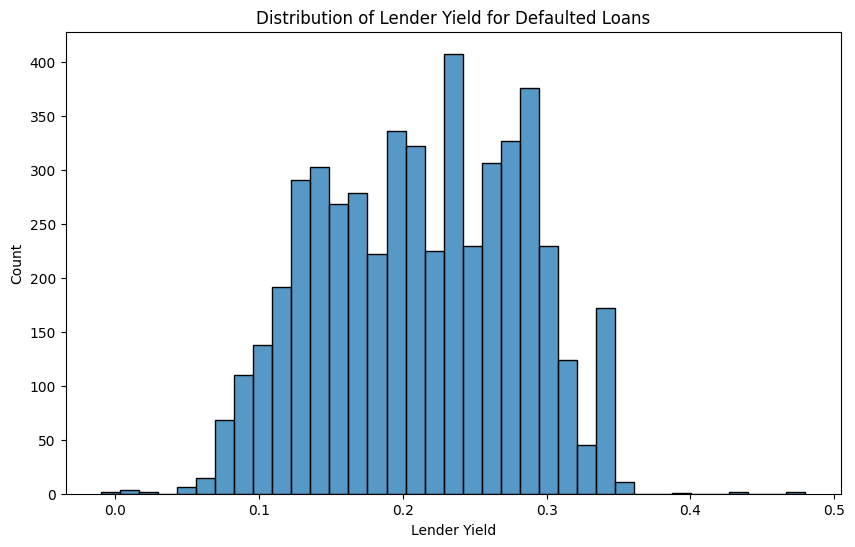

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(defaulted_loans['LenderYield'])
plt.title("Distribution of Lender Yield for Defaulted Loans")
plt.xlabel('Lender Yield')
plt.ylabel('Count')
plt.show()

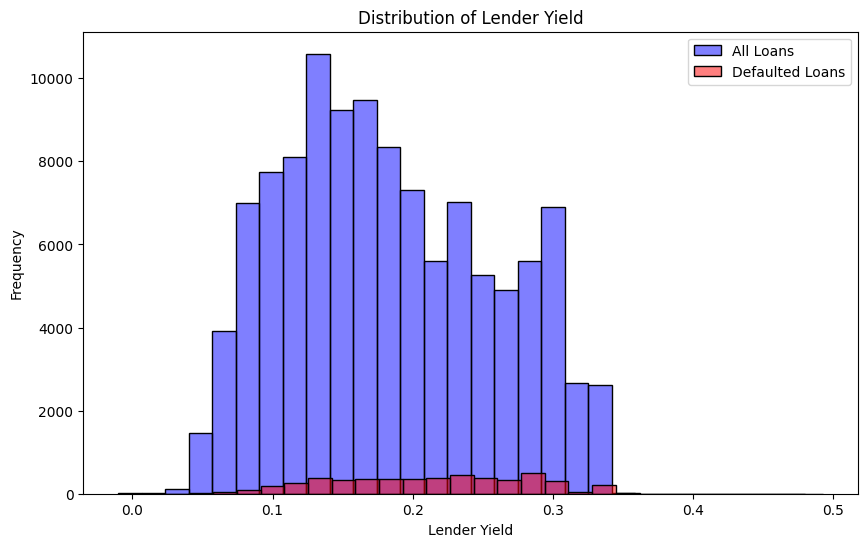

In [ ]:
plt.figure(figsize=(10, 6))

# Determine the bin width based on the overall range of Lender yield
ly_range = features['LenderYield'].max() - features['LenderYield'].min()
ly_binwidth = ly_range / 30

# Plot histogram for all loans (blue)
sns.histplot(features['LenderYield'], color='blue', alpha=0.5, label='All Loans', binwidth=ly_binwidth)

# Plot histogram for defaulted loans (red)
sns.histplot(defaulted_loans['LenderYield'], color='red', alpha=0.5, label='Defaulted Loans', binwidth=ly_binwidth)

plt.title("Distribution of Lender Yield")
plt.xlabel("Lender Yield")
plt.ylabel('Frequency')
plt.legend()
plt.show()

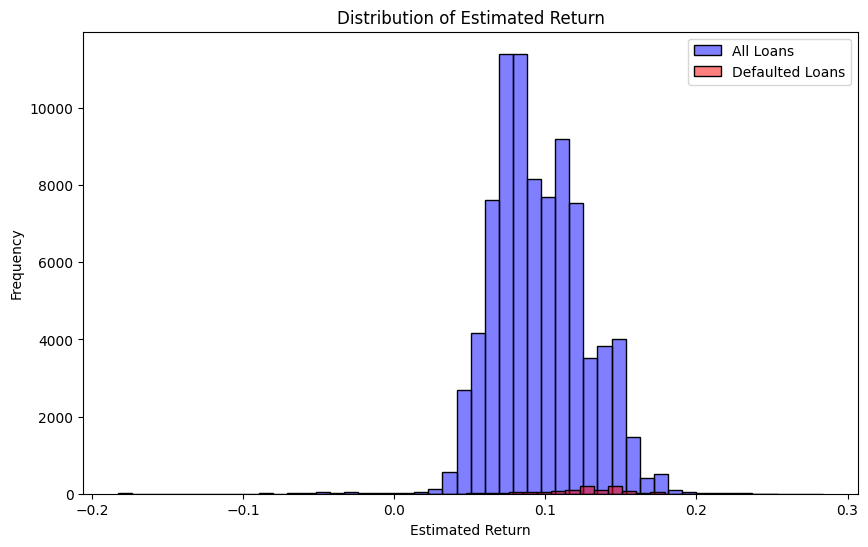

In [ ]:
plt.figure(figsize=(10, 6))

# Determine the bin width based on the overall range of Lender yield
er_range = features['EstimatedReturn'].max() - features['EstimatedReturn'].min()
er_binwidth = er_range / 50

# Plot histogram for all loans (blue)
sns.histplot(features['EstimatedReturn'], color='blue', alpha=0.5, label='All Loans', binwidth=er_binwidth)

# Plot histogram for defaulted loans (red)
sns.histplot(defaulted_loans['EstimatedReturn'], color='red', alpha=0.5, label='Defaulted Loans', binwidth=er_binwidth)

plt.title("Distribution of Estimated Return")
plt.xlabel("Estimated Return")
plt.ylabel('Frequency')
plt.legend()
plt.show()

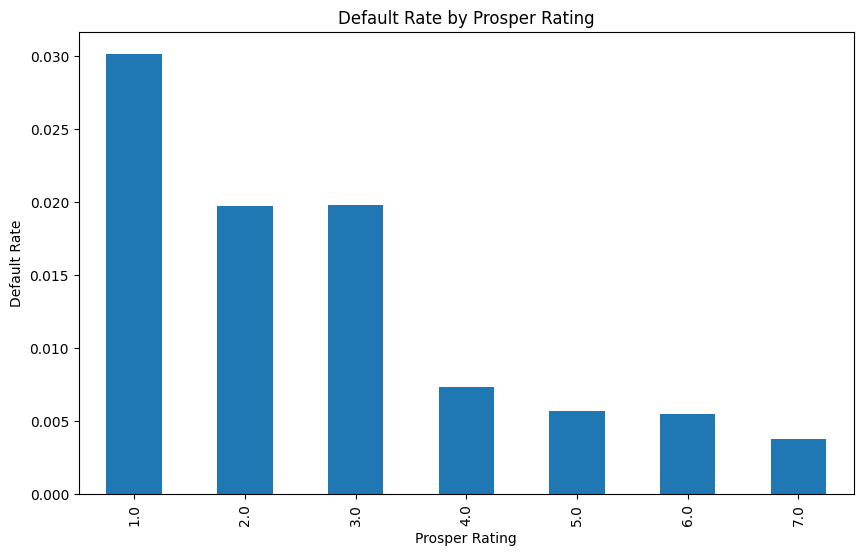

In [ ]:
default_prosper_rating = features.groupby('ProsperRating (numeric)')['LoanStatus'].apply(lambda x: (x == 'Defaulted').mean())

# Create a bar plot to visualize the default rate by prosper rating
plt.figure(figsize=(10, 6))
default_prosper_rating.plot(kind='bar')
plt.title('Default Rate by Prosper Rating')
plt.xlabel('Prosper Rating')
plt.ylabel('Default Rate')
#plt.ylim(0, 1)
plt.show()

6 dummies, omitted one level in the constant term

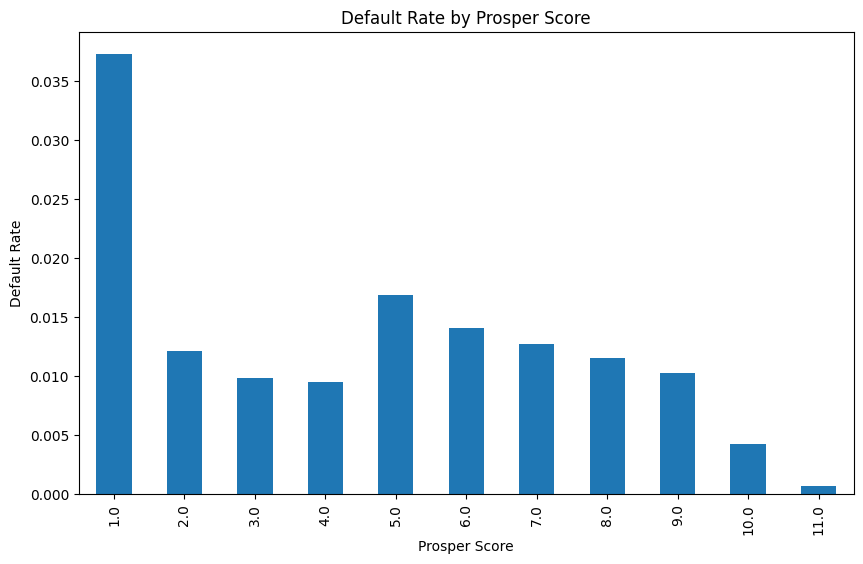

In [ ]:
default_prosper_score = features.groupby('ProsperScore')['LoanStatus'].apply(lambda x: (x == 'Defaulted').mean())

# Create a bar plot to visualize the default rate by prosper score, ranges from 1-10, with 10 being the best/lowest risk
plt.figure(figsize=(10, 6))
default_prosper_score.plot(kind='bar')
plt.title('Default Rate by Prosper Score')
plt.xlabel('Prosper Score')
plt.ylabel('Default Rate')
#plt.ylim(0, 1)
plt.show()

1. dummy for each, or
2. Prosper score <= 5?

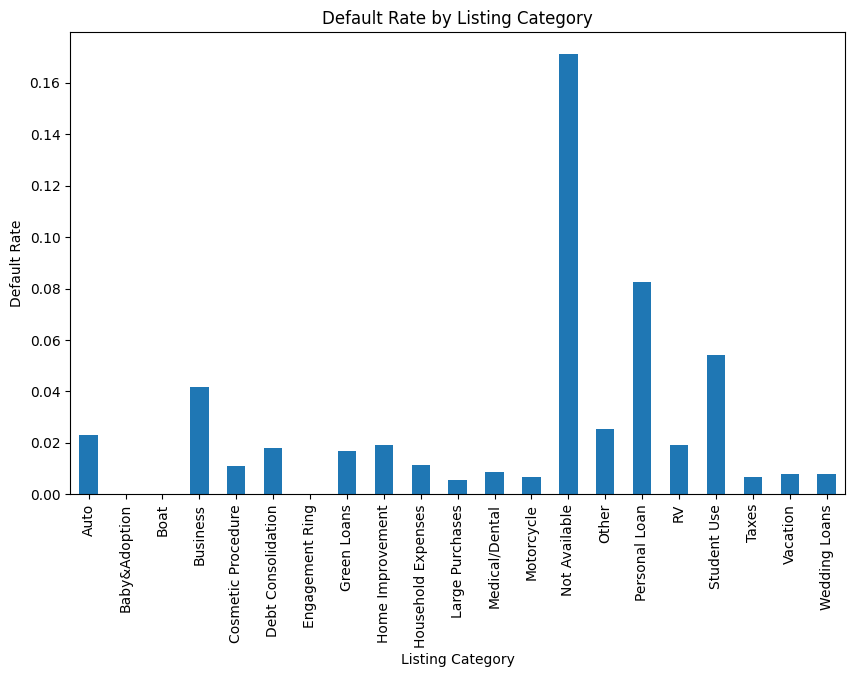

In [ ]:
default_listing_category = features.groupby('ListingCategory')['LoanStatus'].apply(lambda x: (x == 'Defaulted').mean())

plt.figure(figsize=(10, 6))
default_listing_category.plot(kind='bar')
plt.title('Default Rate by Listing Category')
plt.xlabel('Listing Category')
plt.ylabel('Default Rate')
#plt.ylim(0, 1)
plt.show()

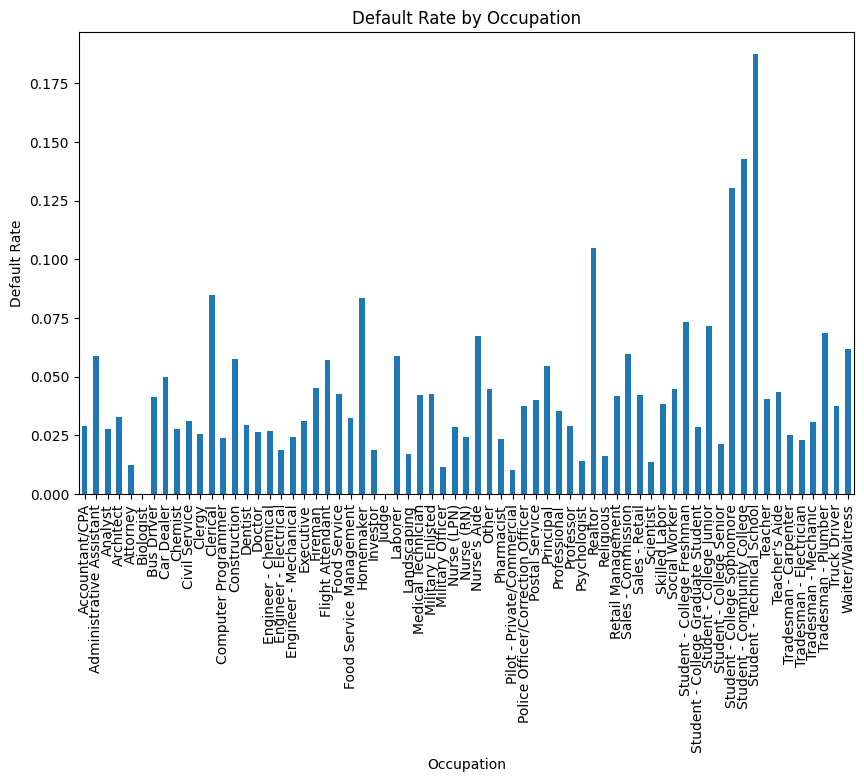

In [ ]:
default_occupation = features.groupby('Occupation')['LoanStatus'].apply(lambda x: (x == 'Defaulted').mean())

plt.figure(figsize=(10, 6))
default_occupation.plot(kind='bar')
plt.title('Default Rate by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Default Rate')
#plt.ylim(0, 1)
plt.show()

1. dummy: is_student
2. other dummies?

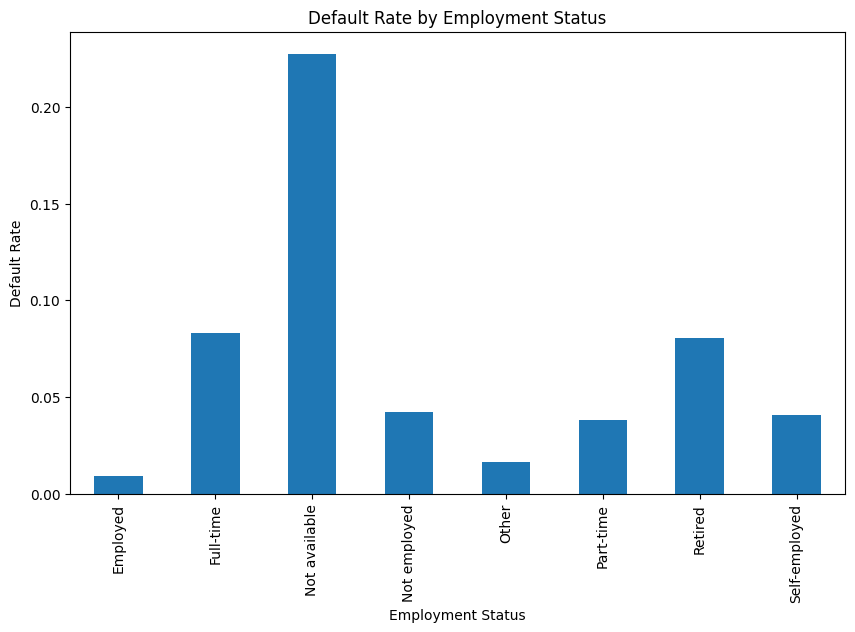

In [ ]:
default_employment = features.groupby('EmploymentStatus')['LoanStatus'].apply(lambda x: (x == 'Defaulted').mean())

plt.figure(figsize=(10, 6))
default_employment.plot(kind='bar')
plt.title('Default Rate by Employment Status')
plt.xlabel('Employment Status')
plt.ylabel('Default Rate')
#plt.ylim(0, 1)
plt.show()

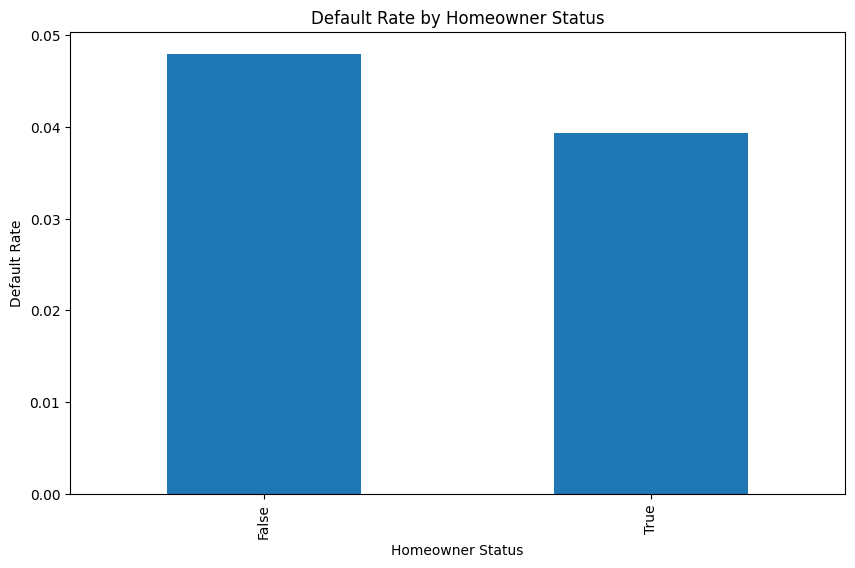

In [ ]:
default_homeowner = features.groupby('IsBorrowerHomeowner')['LoanStatus'].apply(lambda x: (x == 'Defaulted').mean())

plt.figure(figsize=(10, 6))
default_homeowner.plot(kind='bar')
plt.title('Default Rate by Homeowner Status')
plt.xlabel('Homeowner Status')
plt.ylabel('Default Rate')
#plt.ylim(0, 1)
plt.show()

dummy: is_homeowner

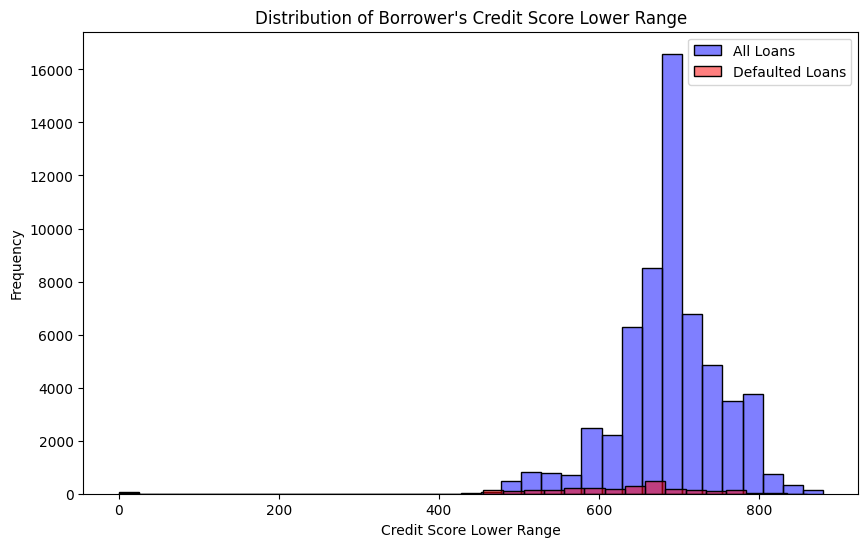

In [ ]:
defaulted_loans = features[features['LoanStatus'] == 'Defaulted']

plt.figure(figsize=(10, 6))

# Determine the bin width based on the overall range of CreditScoreRangeLower
csl_range = features['CreditScoreRangeLower'].max() - features['CreditScoreRangeLower'].min()
csl_binwidth = csl_range / 35

# Plot histogram for all loans (blue)
sns.histplot(features['CreditScoreRangeLower'], color='blue', alpha=0.5, label='All Loans', binwidth=csl_binwidth)

# Plot histogram for defaulted loans (red)
sns.histplot(defaulted_loans['CreditScoreRangeLower'], color='red', alpha=0.5, label='Defaulted Loans', binwidth=csl_binwidth)

plt.title("Distribution of Borrower's Credit Score Lower Range")
plt.xlabel('Credit Score Lower Range')
plt.ylabel('Frequency')
plt.legend()
plt.show()

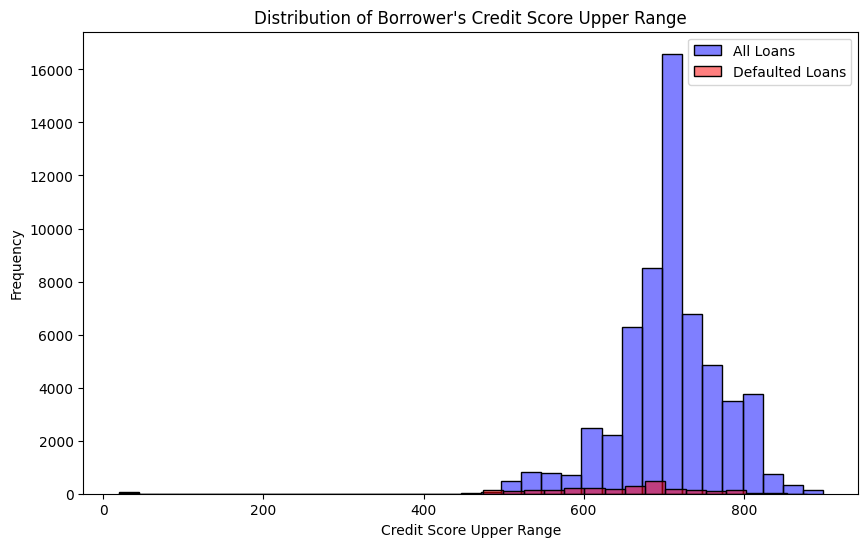

In [ ]:
defaulted_loans = features[features['LoanStatus'] == 'Defaulted']

plt.figure(figsize=(10, 6))

# Determine the bin width based on the overall range of CreditScoreRangeUpper
csu_range = features['CreditScoreRangeUpper'].max() - features['CreditScoreRangeUpper'].min()
csu_binwidth = csu_range / 35

# Plot histogram for all loans (blue)
sns.histplot(features['CreditScoreRangeUpper'], color='blue', alpha=0.5, label='All Loans', binwidth=csu_binwidth)

# Plot histogram for defaulted loans (red)
sns.histplot(defaulted_loans['CreditScoreRangeUpper'], color='red', alpha=0.5, label='Defaulted Loans', binwidth=csu_binwidth)

plt.title("Distribution of Borrower's Credit Score Upper Range")
plt.xlabel('Credit Score Upper Range')
plt.ylabel('Frequency')
plt.legend()
plt.show()

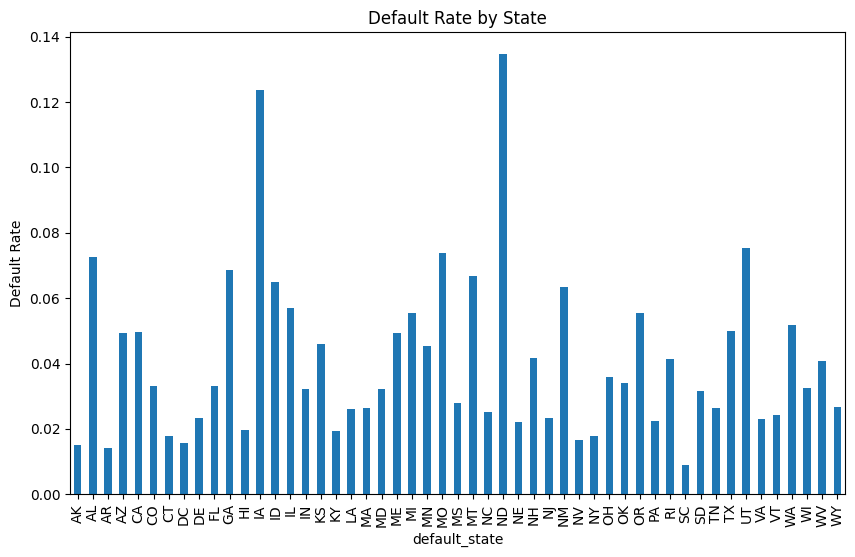

In [ ]:
default_state = features.groupby('BorrowerState')['LoanStatus'].apply(lambda x: (x == 'Defaulted').mean())

plt.figure(figsize=(10, 6))
default_state.plot(kind='bar')
plt.title('Default Rate by State')
plt.xlabel('default_state')
plt.ylabel('Default Rate')
#plt.ylim(0, 1)
plt.show()

Potential predictor exploration

In [ ]:
df_filtered = df[["LoanStatus", "CreditGrade", "BorrowerRate", "ProsperScore","ListingCategory","Occupation","EmploymentStatus","IsBorrowerHomeowner", "IncomeVerifiable", "IncomeRange", "LoanOriginalAmount", "Recommendations", "PercentFunded", "CurrentDelinquencies" , "InquiriesLast6Months", "PublicRecordsLast10Years"]]
df_filtered = df_filtered[df_filtered['LoanStatus'].isin(['Completed', 'Defaulted'])]
df_filtered['Default'] = np.where(df_filtered['LoanStatus'] == 'Completed', 0, 1)

# Compute the percentage of missing values in the dataset.
count = df_filtered.isnull().sum()
percent = (df_filtered.isnull().sum()/43092)
missing_data = pd.concat([count, percent], axis=1, keys=['missing_count', 'missing_percent'])
missing_data.head(100)

,missing_count,missing_percent
LoanStatus,0,0.000000
CreditGrade,20794,0.482549
BorrowerRate,0,0.000000
ProsperScore,22423,0.520352
ListingCategory,0,0.000000
Occupation,1974,0.045809
EmploymentStatus,1961,0.045507
IsBorrowerHomeowner,0,0.000000
IncomeVerifiable,0,0.000000
IncomeRange,0,0.000000


CreditGrade: The Credit rating that was assigned at the time the listing went live. Applicable for listings pre-2009 period and will only be populated for those listings;

ProsperScore: A custom risk score built using historical Prosper data. The score ranges from 1-10, with 10 being the best, or lowest risk score. Applicable for loans originated after July 2009.

In [ ]:
# Read the shapefile
state_shape = gpd.read_file("/content/States_shapefile-shp.zip")
state_shape.rename(columns={'State_Code': 'BorrowerState'}, inplace=True)
sample_states = df["BorrowerState"].unique()

# Filter state_shape to include only states that appear in df_filtered
state_filtered = state_shape[state_shape['BorrowerState'].isin(sample_states)]

default_state_df = default_state.reset_index()
default_state_df.columns = ['BorrowerState', 'Defaulted_Rate']
merged_data = pd.merge(state_filtered, default_state_df, on='BorrowerState', how='left')

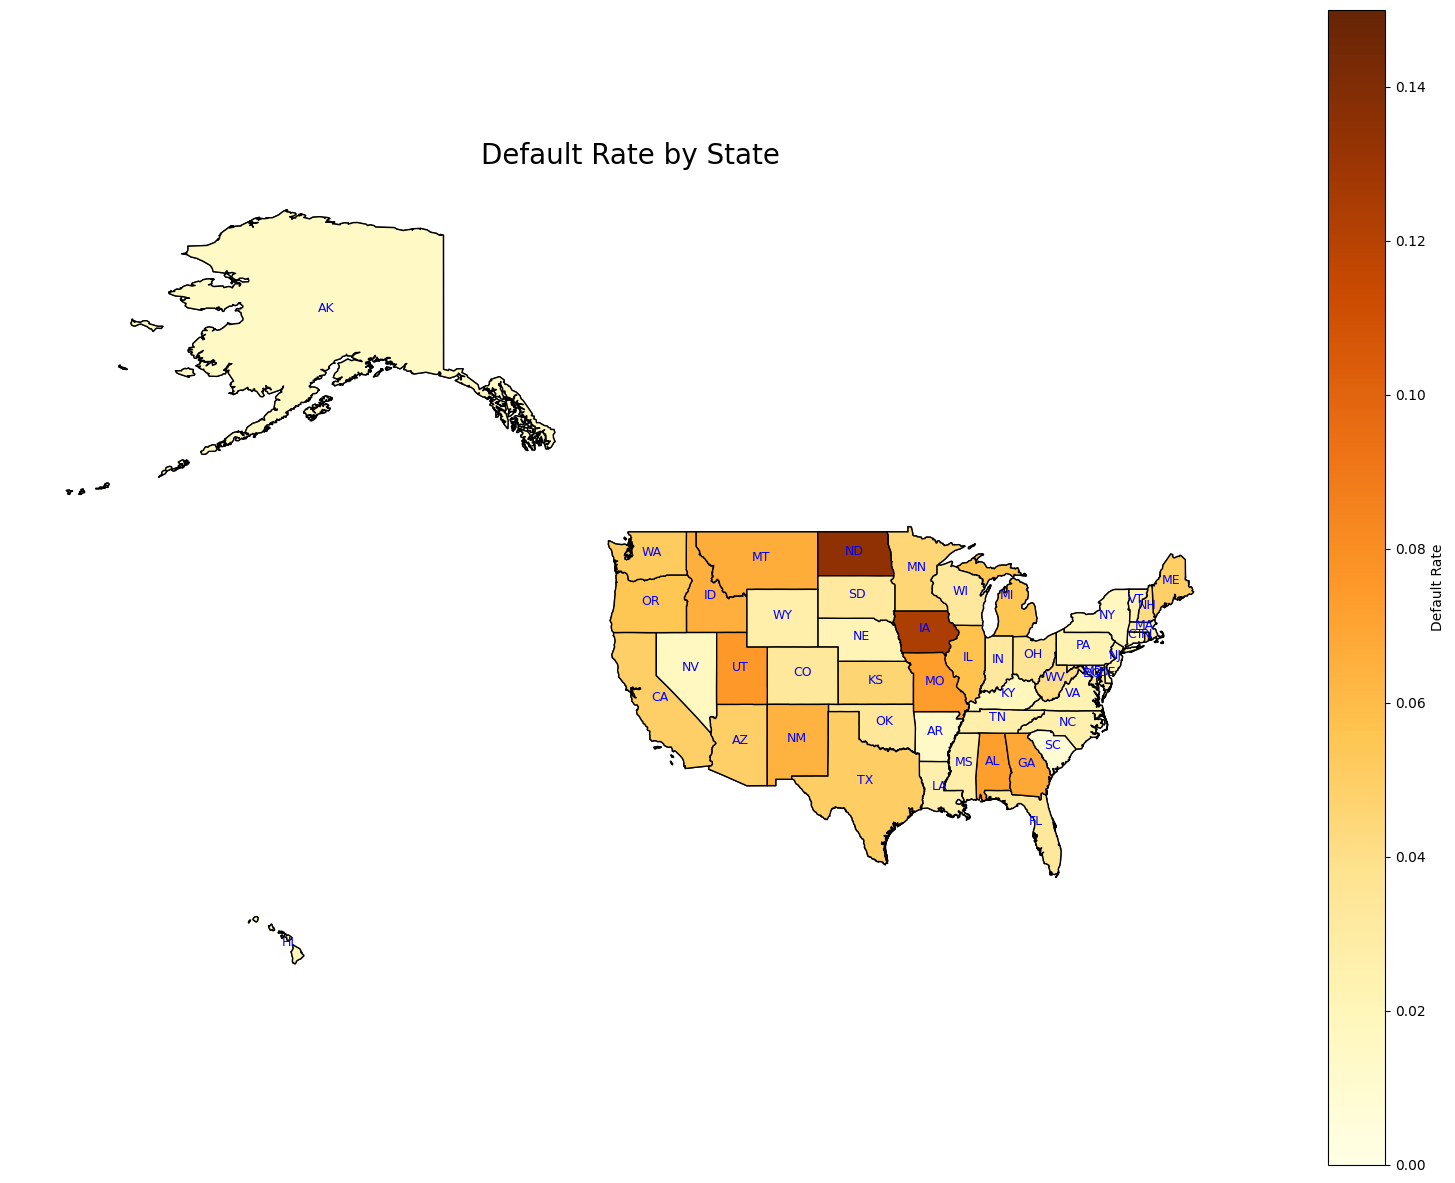

In [ ]:
# Plot the map - default rate by state
fig, ax = plt.subplots(figsize=(20, 15), sharey=True)
base = state_filtered.plot(ax=ax, edgecolor="black", color="white")
merged_data.plot(
    ax=ax, edgecolor='black', column='Defaulted_Rate', legend=True, cmap='YlOrBr', vmin=0, vmax=0.15, legend_kwds={'label': "Default Rate"})
ax.set_title("Default Rate by State", fontsize=20)
ax.axis('off')

for idx, row in merged_data.iterrows():
    ax.text(row.geometry.centroid.x, row.geometry.centroid.y, row['BorrowerState'], fontsize=9, ha='center', color='blue')

plt.show()

<ipython-input-5-d158b5b272c2>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(df_filtered.corr()))
<ipython-input-5-d158b5b272c2>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_filtered.corr(),vmax=1.0,vmin=-1.0, annot=True, cmap='coolwarm',mask=mask)


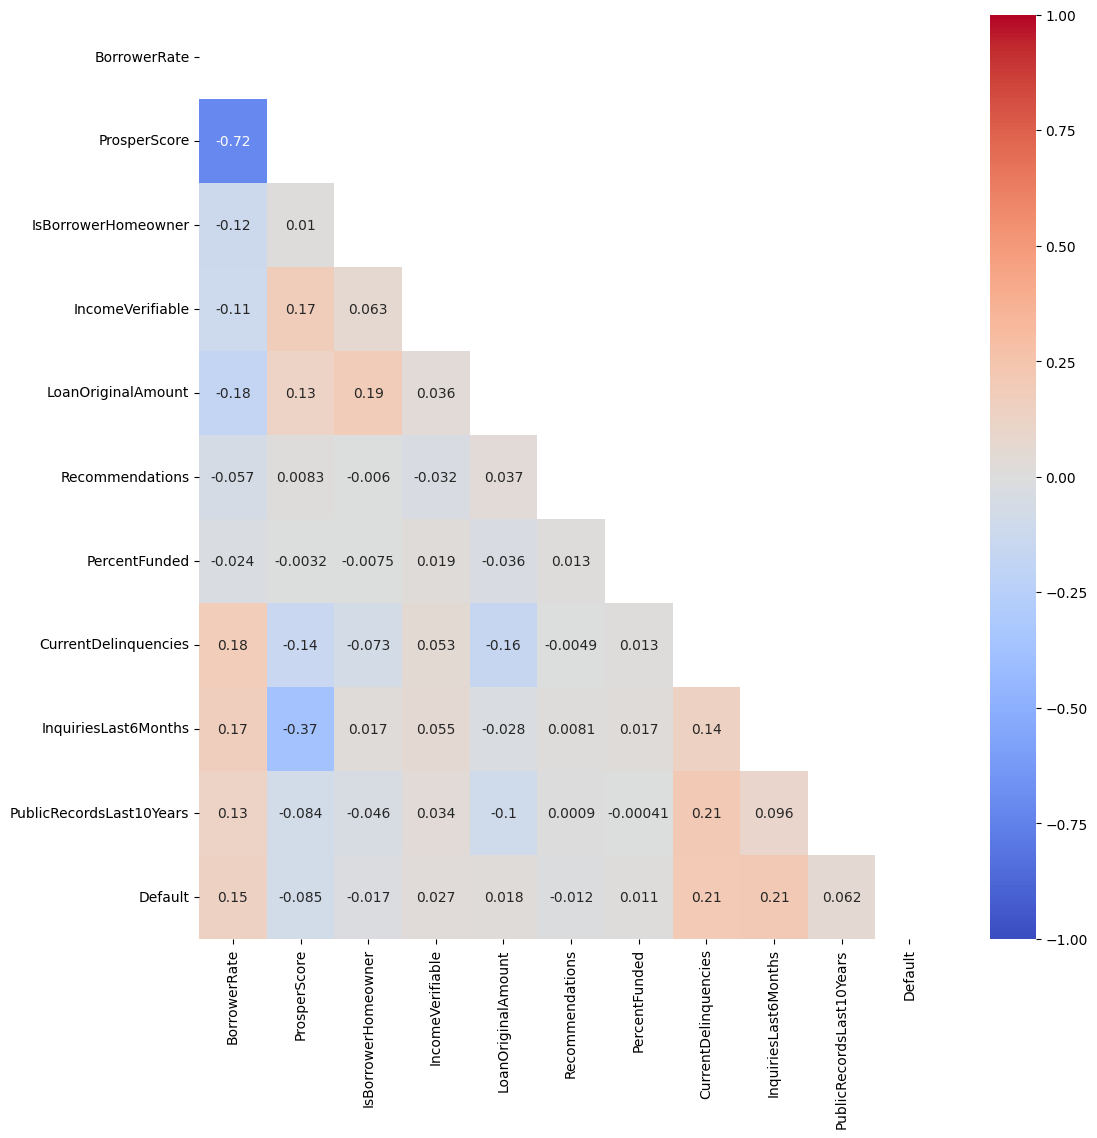

In [ ]:
# Correlation Matrix
plt.figure(figsize=(12,12))
mask = np.triu(np.ones_like(df_filtered.corr()))
sns.heatmap(df_filtered.corr(),vmax=1.0,vmin=-1.0, annot=True, cmap='coolwarm',mask=mask)
plt.show()

In [ ]:
# Creidt grade - omitted: NC
df_filtered['creditgrade_AA'] = np.where(df_filtered['CreditGrade'] == 'AA', 1, 0)
df_filtered['creditgrade_A'] = np.where(df_filtered['CreditGrade'] == 'A', 1, 0)
df_filtered['creditgrade_B'] = np.where(df_filtered['CreditGrade'] == 'B', 1, 0)
df_filtered['creditgrade_C'] = np.where(df_filtered['CreditGrade'] == 'C', 1, 0)
df_filtered['creditgrade_D'] = np.where(df_filtered['CreditGrade'] == 'D', 1, 0)
df_filtered['creditgrade_E'] = np.where(df_filtered['CreditGrade'] == 'E', 1, 0)
df_filtered['creditgrade_HR'] = np.where(df_filtered['CreditGrade'] == 'HR', 1, 0)

# Income range - omitted: Not displayed
df_filtered['no_income'] = np.where(df_filtered['IncomeRange'].isin(['$0', 'Not employed']), 1, 0)
df_filtered['income_below25k'] = np.where(df_filtered['IncomeRange'] == '$1-24,999', 1, 0)
df_filtered['income_25k_50k'] = np.where(df_filtered['IncomeRange'] == '$25,000-49,999', 1, 0)
df_filtered['income_50k_75k'] = np.where(df_filtered['IncomeRange'] == '$50,000-74,999', 1, 0)
df_filtered['income_75k_100k'] = np.where(df_filtered['IncomeRange'] == '$75,000-99,999', 1, 0)
df_filtered['income_greater100k'] = np.where(df_filtered['IncomeRange'] == '$100,000+', 1, 0)

# Homeowner - ommited: No
df_filtered['is_homeowner'] = np.where(df_filtered['IsBorrowerHomeowner'] == 'True', 1, 0)

# Income verifiable - omitted: No
df_filtered['income_verifiable'] = np.where(df_filtered['IncomeVerifiable'] == 'True', 1, 0)

In [ ]:
# Create the dummy for students
students = ['Student - College Senior', 'Student - College Graduate Student',
                       'Student - Technical School', 'Student - College Junior',
                       'Student - Community College', 'Student - College Freshman',
                       'Student - College Sophomore']

df_filtered['is_student'] = np.where(df_filtered['Occupation'].isin(students), 1, 0)

In [ ]:
# Re-categorize the employment status
def categorize_employment(status):
    if status in ['Employed', 'Full-time', 'Part-time', 'Self-employed']:
        return 'Yes'
    elif status in ['Not employed', 'Retired']:
        return 'No'
    else:
        return 'Not Available or Others'

df_filtered['Employment'] = df_filtered['EmploymentStatus'].apply(categorize_employment)

# Employment status - omitted: Not Available or Others
df_filtered['employment_yes'] = np.where(df_filtered['Employment'] == 'True', 1, 0)
df_filtered['employment_no'] = np.where(df_filtered['Employment'] == 'No', 1, 0)

In [ ]:
# Re-categorize the listing category status
def categorize_listing(category):
    if category in ['Not Available']:
        return 'No'
    else:
        return 'Yes'

df_filtered['ReportedLoanPurpose'] = df_filtered['ListingCategory'].apply(categorize_listing)

# Reported purpose - omitted: No (NOT reported)
df_filtered['reported_purpose'] = np.where(df_filtered['ReportedLoanPurpose'] == 'Yes', 1, 0)

In [ ]:
# Drop original, uncleaned columns
df_filtered = df_filtered.drop(columns = ['LoanStatus', 'CreditGrade', 'IsBorrowerHomeowner', 'Occupation', 'EmploymentStatus', 'Employment', 'ListingCategory', 'IncomeRange', 'IncomeVerifiable', 'ReportedLoanPurpose'])

In [ ]:
# Normalize data before KNN imputation - otherwise the difference in scales of each prediction may lead to biased imputed values
scaler = MinMaxScaler()
df_filtered = pd.DataFrame(scaler.fit_transform(df_filtered), columns = df_filtered.columns)

# KNN imputation - fill in each missing value by using values of its 5 nearest neighbors (with smallest euclidean distances), uniformly weighted
imputer = KNNImputer(n_neighbors=5, weights="uniform")
X_imputed = imputer.fit_transform(df_filtered.drop(columns=['Default']))

# Convert the imputed array back to a dataframe, since the state and year dummies will be added later
X_imputed_df = pd.DataFrame(X_imputed, columns=df_filtered.drop(columns=['Default']).columns)

In [ ]:
# Add dummies for fixed effects
df = df[df['LoanStatus'].isin(['Completed', 'Defaulted'])]
df["Year"] = pd.to_datetime(df['ListingCreationDate']).dt.year
temp = df[["Year", "BorrowerState"]]
temp = temp.reset_index(drop=True)

X_imputed_df = pd.concat([X_imputed_df, temp], axis=1)
X_imputed_df["BorrowerState"].fillna("Unknown", inplace=True)

year_dummies = pd.get_dummies(X_imputed_df["Year"], prefix="Year", drop_first=True)
state_dummies = pd.get_dummies(X_imputed_df["BorrowerState"], prefix="State", drop_first=True)
X_imputed_df = pd.concat([X_imputed_df, year_dummies, state_dummies], axis=1)
X_imputed_df.drop(columns=['Year', 'BorrowerState'], inplace=True)
X_imputed_df

<ipython-input-12-b03e514e0b1d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Year"] = pd.to_datetime(df['ListingCreationDate']).dt.year


,BorrowerRate,ProsperScore,LoanOriginalAmount,Recommendations,PercentFunded,CurrentDelinquencies,InquiriesLast6Months,PublicRecordsLast10Years,creditgrade_AA,creditgrade_A,creditgrade_B,creditgrade_C,creditgrade_D,creditgrade_E,creditgrade_HR,no_income,income_below25k,income_25k_50k,income_50k_75k,income_75k_100k,income_greater100k,is_homeowner,income_verifiable,is_student,employment_yes,employment_no,reported_purpose,Year_2006,Year_2007,Year_2008,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_Unknown,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
0,0.317588,0.52,0.247794,0.000000,0.96463,0.024096,0.047619,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.552764,0.50,0.058853,0.000000,0.96463,0.012048,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.266332,0.60,0.000000,0.000000,0.96463,0.036145,0.047619,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0.638593,0.40,0.088235,0.000000,0.96463,0.000000,0.000000,0.045455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.417085,0.58,0.058824,0.000000,0.96463,0.012048,0.000000,0.045455,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43087,0.582915,0.50,0.058824,0.000000,0.96463,0.216867,0.031746,0.318182,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43088,0.136482,0.88,0.096824,0.051282,0.96463,0.000000,0.015873,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
43089,0.381709,0.50,0.029412,0.000000,0.96463,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43090,0.530452,0.20,0.044118,0.000000,0.96463,0.000000,0.031746,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Separate features and target variables
X = X_imputed_df
y = df_filtered['Default']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1006693712)

In [ ]:
model_logistic = LogisticRegression(max_iter=1000)

# Stepwise feature selection
stepwise_selection = SequentialFeatureSelector(model_logistic, n_features_to_select=15, direction='forward', cv=5)
stepwise_selection.fit(X_train, y_train)

# Print the selected features
stepwise_features = X.columns[stepwise_selection.get_support(indices=True)]
print("Features determined by forward stepwise selection:", stepwise_features)

Features determined by forward stepwise selection: Index(['BorrowerRate', 'ProsperScore', 'CurrentDelinquencies',
       'InquiriesLast6Months', 'creditgrade_AA', 'creditgrade_HR',
       'income_75k_100k', 'reported_purpose', 'Year_2006', 'State_ID',
       'State_MA', 'State_MI', 'State_NC', 'State_NY', 'State_Unknown'],
      dtype='object')


In [ ]:
# Keep predictor variables selected by the stepwise selection
X_stepwise = X[stepwise_features]

# Split the data into training and testing sets
X_stepwise_train, X_stepwise_test, y_stepwise_train, y_stepwise_test = train_test_split(X_stepwise, y, test_size=0.25, random_state=1006693712)

# Fit a logistic regression using features selected by forward stepwise selection
model_logistic.fit(X_stepwise_train, y_stepwise_train)

# Predict on the test set
y_stepwise_pred = model_logistic.predict(X_stepwise_test)

# Calculate the accuracy score
accuracy_stepwise = accuracy_score(y_stepwise_test, y_stepwise_pred)
print("The prediction accuracy by the logistic regression model with predictors selected by stepwise selection:", accuracy_stepwise)

The prediction accuracy by the logistic regression model with predictors selected by stepwise selection: 0.9002134967047247


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
conf_matrix = confusion_matrix(y_stepwise_test, y_stepwise_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[9513   77]
 [ 998  185]]
